# WORKFLOW 1

In [1]:
# DEFINE IMPORTANT VARIABLES

# Define variables for TEST-BM
test_bm_vus = 5
test_bm_duration = "90s"

# Define percent of improvement for function-optimized
# bm_threshold_improvement = 7.5
bm_threshold_improvement = 5
# bm_threshold_improvement = 2.5

# Define variables for FUNCTION EXECUTION
vus = 5
duration = 30
duration_with_format = str(duration) + "m" # time formats: s, m, h

# Define how many minutes back we have to fetch
fetch_minutes_back = int(duration + (0.25 * duration))

### Execute Functions

##### Calculate median execution time for benchmark

In [ ]:
# Construct the command
command_test_bm = f"cd ../loadtesting/test-benchmark && k6 run --env VUS={test_bm_vus} --env DURATION={test_bm_duration} script.js"

# Run the command
get_ipython().system(f"{command_test_bm}")

In [ ]:
import json

file_path = "../loadtesting/test-benchmark/summary.json"

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Access the values of 'min' and 'med'
min_value_sec = data['total_duration']['values']['min']
avg_value_sec = data['total_duration']['values']['avg'] # changed from med to avg
max_value_sec = data['total_duration']['values']['max']

# Convert seconds to microseconds
min_value_us = int(min_value_sec * 1_000_000)
avg_value_us = int(avg_value_sec * 1_000_000)
max_value_us = int(max_value_sec * 1_000_000)

# Print the results
print(f"Min: {min_value_us} µs")
print(f"Avg: {avg_value_us} µs")
print(f"Max: {max_value_us} µs")

percent_improvement = bm_threshold_improvement / 100
bm_max_duration = str(avg_value_us - int(percent_improvement * avg_value_us))
print("\nBM threshold: " + bm_max_duration + " µs")

##### Load test GCP-Functions: OPTIMIZED and BASELINE

In [ ]:
# Define max bm duration and add param to url
maxBenchmarkDuration = bm_max_duration + "us" if bm_max_duration else "3850us"
optimized_url = f"https://europe-west3-bsc-thesis-implementation.cloudfunctions.net/optimizedFunction?maxBenchmarkDuration={maxBenchmarkDuration}"

# Construct the individual commands for each `k6` run
command_optimized = f"cd ../loadtesting/test-function-optimized && k6 run --env URL='{optimized_url}' --env VUS={vus} --env DURATION={duration_with_format} script.js"
command_baseline = f"cd ../loadtesting/test-function-baseline && k6 run --env VUS={vus} --env DURATION={duration_with_format} script.js"

# Run both commands in the background
get_ipython().system(f"({command_optimized}) & ({command_baseline})")

---

### Fetch data

##### Import PYTHON modules

In [5]:
import sys 
import os
from datetime import datetime
sys.path.append(os.path.abspath("logs_fetch"))

from logs_fetch.logs_fetch import PROJECT_ID
from logs_fetch.logs_fetch import CloudFunction
from logs_fetch.logs_fetch import fetch_logs_and_save

from logs_metrics.calc_median_function_execution import return_median_function_execution_BASELINE
from logs_metrics.calc_median_function_execution import return_median_function_execution_OPTIMIZED

from logs_metrics.calc_median_download import return_median_download_BASELINE
from logs_metrics.calc_median_download import return_median_download_OPTIMIZED

from logs_metrics.calc_median_lr_duration import return_median_lr_duration_BASELINE
from logs_metrics.calc_median_lr_duration import return_median_lr_duration_OPTIMIZED

##### Setup folder

In [6]:
# SETUP FOLDER FOR LOGS
base_folder_path = "./logs_archive"
today_date = datetime.now().strftime("%Y-%m-%d")
date_folder = os.path.join(base_folder_path, today_date)

# Create the directory if it doesn't exist
os.makedirs(date_folder, exist_ok=True)
    
# Check the number of existing subfolders for today's date
existing_folders = [f.name for f in os.scandir(date_folder) if f.is_dir()]
execution_count = len(existing_folders) + 1  # Increment folder name based on the existing number of folders
    
# Create a unique subfolder for this execution
execution_folder_path = os.path.join(date_folder, f"execution_{execution_count}")
os.makedirs(execution_folder_path, exist_ok=True)

##### Fetch logs

In [ ]:
fetch_logs_and_save(CloudFunction.OPTIMIZED, PROJECT_ID, fetch_minutes_back, execution_folder_path)

In [ ]:
fetch_logs_and_save(CloudFunction.BASELINE, PROJECT_ID, fetch_minutes_back, execution_folder_path)

---

### Perform Analysis

In [9]:
# Create folder and path
import os
from datetime import datetime

today_date = datetime.now().strftime("%Y-%m-%d")

# Define the folder path for saving plots
base_folder_path = os.path.join(os.getcwd(), "seaborn_plots", today_date)
# Create the directory if it doesn't exist
os.makedirs(base_folder_path, exist_ok=True)

# Check the number of existing subfolders for today's date
existing_folders = [f.name for f in os.scandir(base_folder_path) if f.is_dir()]
execution_count = len(existing_folders) + 1  # Increment folder name based on the existing number of folders

# Create a unique subfolder for this execution
execution_folder = os.path.join(base_folder_path, f"execution_{execution_count}")
os.makedirs(execution_folder, exist_ok=True)

##### Calculate Metrics

In [ ]:
import pandas as pd
median_function_execution = return_median_function_execution_BASELINE(execution_count), return_median_function_execution_OPTIMIZED(execution_count)
median_download_duration = return_median_download_BASELINE(execution_count), return_median_download_OPTIMIZED(execution_count)
median_lr_duration = return_median_lr_duration_BASELINE(execution_count), return_median_lr_duration_OPTIMIZED(execution_count)

data = {
    "Metric": ["Function Execution Time", "Download Duration", "Linear Regression Execution Time"],
    "Baseline": [median_function_execution[0], median_download_duration[0], median_lr_duration[0]],
    "Optimized": [median_function_execution[1], median_download_duration[1], median_lr_duration[1]],
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate % Improvement and add as a new column
df["% Improvement"] = ((df["Baseline"] - df["Optimized"]) / df["Baseline"]) * 100

# Save table
file_name = "table.json"
output_path = os.path.join(execution_folder, file_name)
df.to_json(output_path, orient="records", indent=4)

# Display DataFrame
# print(df)

# Conditional styling
styled_df = df.style.format({"Baseline": "{:.1f}", "Optimized": "{:.1f}", "% Improvement": "{:.1f}"}) \
                    .map(lambda x: 'color: red;' if x < 0 else 'color: green;', subset=["% Improvement"]) \
                   .set_table_styles([{
                       'selector': 'thead th', 
                       'props': [
                           ('background-color', '#f2f2f2'), 
                           ('color', 'black'), 
                           ('font-size', '16px'), 
                           ('text-align', 'center')
                           ],
                       }
                       ]) \
                   .set_properties(**{
                       'border': '1px solid black',
                       'text-align': 'center',
                       'font-size': '14px',
                       'padding': '10px',
                   }) \
                   .hide(axis="index")

# Display the styled DataFrame
styled_df

---

### Create Graphics with Seaborn

#### Imports and Load data

In [8]:
# IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

today_date = datetime.now().strftime("%Y-%m-%d")

df_optimized = pd.read_csv(f"./logs_archive/{today_date}/execution_{execution_count}/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_archive/{today_date}/execution_{execution_count}/{today_date}-baselineFunction-logs.csv")

# Adjust window size as needed
window_size = 50

# Convert 'timestamp' col to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])
# Create col duration in minutes for x-axis
df_optimized['duration_minutes'] = (df_optimized['timestamp'] - df_optimized['timestamp'].min()).dt.total_seconds() / 60
df_baseline['duration_minutes'] = (df_baseline['timestamp'] - df_baseline['timestamp'].min()).dt.total_seconds() / 60
# Create col for smoothed execution time
df_optimized['smoothed_execution_time'] = df_optimized['execution_time'].rolling(window=window_size).mean()
df_baseline['smoothed_execution_time'] = df_baseline['execution_time'].rolling(window=window_size).mean()
# Create col for smoothed lr-duration
df_optimized = df_optimized[df_optimized['lr_duration'] != 0] # filter out zeros
df_optimized['smoothed_lr_duration'] = df_optimized['lr_duration'].rolling(window=window_size).mean()
df_baseline['smoothed_lr_duration'] = df_baseline['lr_duration'].rolling(window=window_size).mean()

df_optimized = df_optimized[df_optimized['lr_duration'] != 0]


#### Execution Time

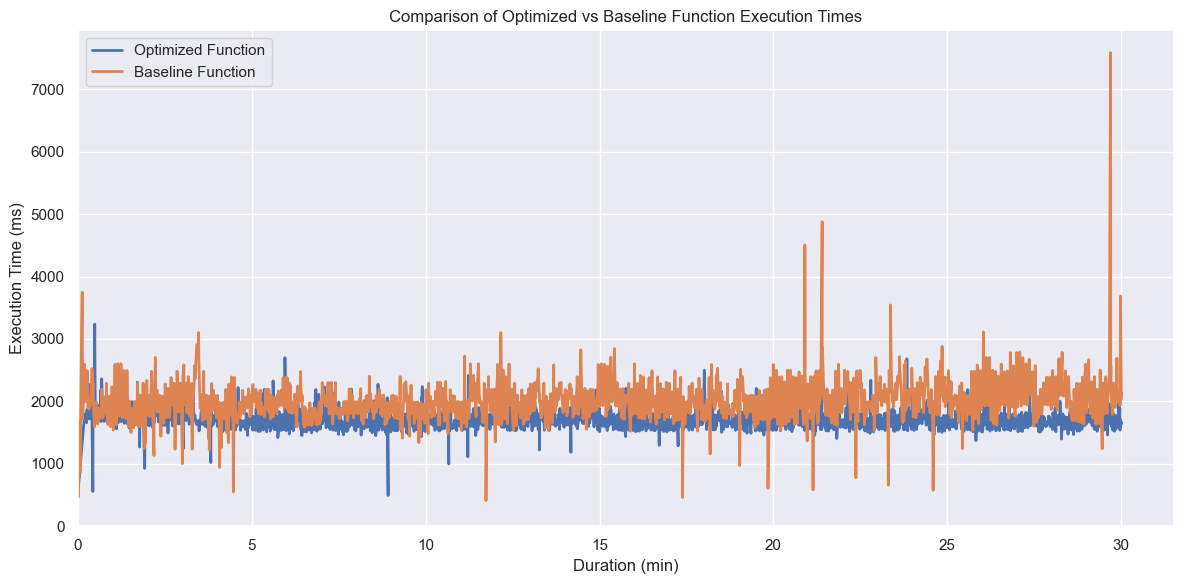

In [9]:
# CREATE PLOT
sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot for optimized and baseline function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='execution_time', color=palette[0], label='Optimized Function', lw=2)
sns.lineplot(data=df_baseline, x='duration_minutes', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(execution_folder, "execution-times.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

##### Execution Time Rolling Avg

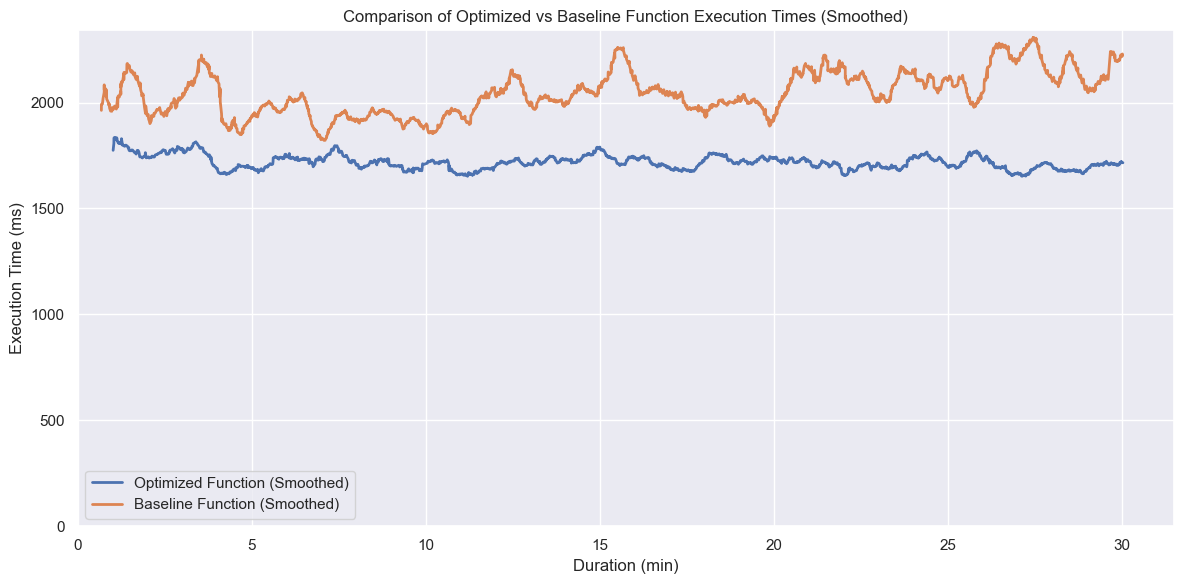

In [10]:
# CREATE PLOT
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='smoothed_execution_time', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='smoothed_execution_time', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(execution_folder, "execution-times-rolling-avg.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

---

#### LR Duration

In [11]:
# Filter out zeros from crashed instances
df_optimized = df_optimized[df_optimized['lr_duration'] != 0]

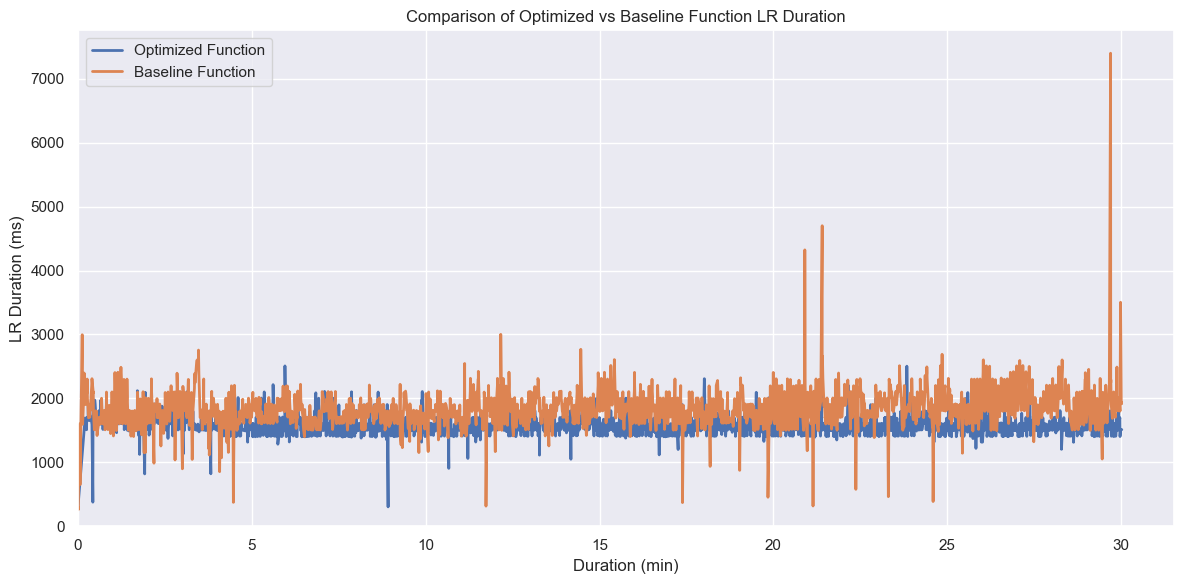

In [12]:
# CREATE PLOT
sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='lr_duration', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='lr_duration', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('LR Duration (ms)')
plt.title('Comparison of Optimized vs Baseline Function LR Duration')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(execution_folder, "lr-duration.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 
plt.show() 

##### LR Duration Rolling Avg

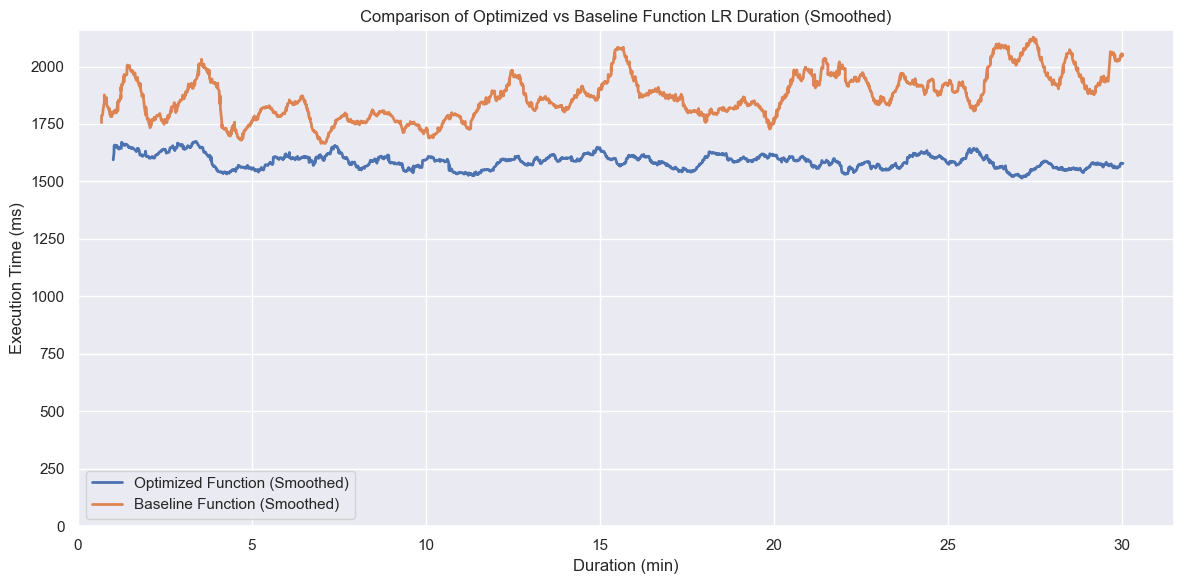

In [13]:
# CREATE PLOT
sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='smoothed_lr_duration', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='smoothed_lr_duration', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function LR Duration (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(execution_folder, "lr-duration-rolling-avg.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

---